In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calculate du^ n / dt^n for arbitrary n and use this to create a loss term
def higher_order_loss_term(weight, outputs, t, norm_term, forcing_funct):
    
    # compute derivative of outputs with respect to inputs 
    deriv_to_t = torch.autograd.grad(outputs, t, grad_outputs=torch.ones_like(outputs), 
                                 create_graph=True)[0]
        
    # additional loss term
#     loss_term = norm_term * weight * torch.mean((deriv_to_t - forcing_funct) ** 2)
    loss_term = weight * torch.mean((deriv_to_t - forcing_funct) ** 2)
    
    return loss_term, deriv_to_t

# build the loss function
def loss(t, A, lambda_val, model, loss_term_weights):
            
    # create the trial solution
    u_t = lambda t: model(t)[0] # TODO: this is weird, just use model(t)[0] directly, no lambda function needed

    # normalize loss and use it to compute the normalization factor
    norm_term = 1 / u_t(torch.tensor([[0]], dtype=torch.float32)) ** 2
    
    # initialize all loss terms in case they do not need to be computed
    L_D, L_DD, L_DDD, L_DDDD = [torch.tensor([[0.]])] * 4
    
    # loss results
    loss_dict = {}
    
    # define f (aka forcing function)
    f = lambda t, u: -lambda_val * u # TODO: remove minus here and change loss_term above to deriv_to_t + forcing_funct
    # compute u(t)
    outputs = u_t(t)
    
    # initial value loss terms
    initial_val_loss = (A - u_t(torch.tensor([[0]], dtype=torch.float32)))**2
        
    # computes residual (function call also returns du / dt as u_t_x)
    L_D, u_t_x = higher_order_loss_term(loss_term_weights[0], outputs, t, norm_term, f(t, outputs))
                
#     if loss_term_weights[1] or loss_term_weights[2] or loss_term_weights[3]:
#         # define f' (derivative of f)
#         f_t = -lambda_val * u_t_x
#         # first derivative of residual (function call also returns d^2u / dt^2 as u_tt_x)
#         L_DD, u_tt_x = higher_order_loss_term(loss_term_weights[1], u_t_x, t, norm_term, f_t)

#     if loss_term_weights[2] or loss_term_weights[3]:
#         # define f'' (derivative of f')
#         f_tt = -lambda_val * u_tt_x
#         # second derivative of residual (function call also returns d^3u / dt^3 as u_ttt_x)
#         L_DDD, u_ttt_x = higher_order_loss_term(loss_term_weights[2], u_tt_x, t, norm_term, f_tt)
        
#     if loss_term_weights[3]:
#         # define f''' (derivative of f'')
#         f_ttt = -lambda_val * u_ttt_x
#         # third derivative of residual (function call also returns d^4u / dt^4 as u_tttt_x)
#         L_DDDD, u_tttt_x = higher_order_loss_term(loss_term_weights[3], u_ttt_x, t, norm_term, f_ttt)
        
    # total loss 
    L_total = L_D + L_DD + L_DDD + L_DDDD + initial_val_loss
    
    loss_dict['L_D'] = L_D
    loss_dict['L_DD'] = L_DD
    loss_dict['L_DDD'] = L_DDD
    loss_dict['L_DDDD'] = L_DDDD
    loss_dict['L_total'] = L_total

    return loss_dict


In [3]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size):
        super(BuildNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        self.output = nn.Linear(h_size3, output_size)
        
    def forward(self, x):
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result) # this is H...
        result = self.output(h)
        
        return result, h

In [ ]:
# Old Model Code: 
# model = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64,1))

# Old trial solution parametrization: 
# u_t = lambda t: A + (1 - torch.exp(-t)) * model(t)

In [40]:
# train and evaluate the model
def run_model(iterations, min_x, max_x, A_vals, lambda_val, loss_term_weights):
    
    assert sum(loss_term_weights) != 0, "ERROR: Invalid Loss Function"
    
    for idx, num in enumerate(loss_term_weights[:-1]):
        next_num = loss_term_weights[idx + 1]
        assert next_num <= num, 'ERROR: Invalid Loss Function'
      
    # build the neural net model
    model = BuildNetwork(1, 9, 9, 9, 1) # originally: (1, 64, 64, 64, 1)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # starting initial value for transfer learning
    curr_A_indx = 0
    A = A_vals[curr_A_indx]
    print(f"Initial Condition: {A}")
    # run the training loop
    for i in range(iterations):
        
        if i % 1000 == 0 and i != 0: 
            curr_A_indx +=1 
            A = A_vals[curr_A_indx]
            print(f"Initial Condition: {A}")
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        curr_loss = loss(x, A, lambda_val, model, loss_term_weights)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].item())
        loss_history['LDD_losses'].append(curr_loss['L_DD'].item())
        loss_history['LDDD_losses'].append(curr_loss['L_DDD'].item())
        loss_history['LDDDD_losses'].append(curr_loss['L_DDDD'].item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
        # compute the mse
        with torch.no_grad():
            true_sol = (A * np.exp(-lambda_val * x)).numpy()
            network_sol = model(x)[0].numpy()
        current_mse = np.mean((true_sol - network_sol) ** 2)
        MSEs.append(current_mse)
   
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

In [41]:
# function to plot the neural network vs exact solution
def plot_solution(min_x, max_x, A, lambda_val, trained_model, axis):
    
    u_t = lambda t: trained_model(t)[0]
#     u_t = lambda t: A + (1 - torch.exp(-t)) * trained_model(t)

    # plot the solution accuracies
    xx = np.linspace(min_x, max_x, 200)[:, None]

    with torch.no_grad():
        yy = u_t(torch.Tensor(xx)).numpy()

    yt = A * np.exp(-lambda_val * xx)

    axis.plot(xx, yt, label='Actual Solution')
    axis.plot(xx, yy, '--', label='Neural Network Solution')
    axis.set_title("u(t) vs t for Actual and Approximation")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis):
    axis.plot(range(iterations), mses, label='MSE')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss of the network solution
def plot_loss_mse_and_solution(min_x, max_x, A, lambda_val, iterations, 
                               trained_model, train_losses, loss_label, mses):
    fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    plot_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, 
                  trained_model=trained_model, axis=axs[1])
    plot_mse(iterations=iterations, mses=mses, axis=axs[2])
    
    plt.show()
    
# function to plot the loss terms for a given model
def plot_individual_loss_terms(iterations, loss_dictionary):
    
    plt.figure(figsize=(9, 9))
    for label, losses in loss_dictionary.items():
        plt.plot(range(iterations), losses, label=label)
        
    plt.yscale("log")
    plt.title("Loss Terms vs Iterations")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [42]:
# set-up differential equation parameters for network
min_x, max_x = 0, 2
A_vals = [0.9, 0.2, 0.35, 0.75]
# A_vals = [0.9, 0.9, 0.9, 0.9]
lambda_val = 1
iterations = 4000

# run model which has a loss of the MSE (i.e. no higher order terms)
loss_history_w1, trained_model_w1, time_w1, MSE_w1 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                              lambda_val=lambda_val, loss_term_weights=[1, 0, 0, 0])

# # run model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
# loss_history_w2, trained_model_w2, time_w2, MSE_w2 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A=A, 
#                                                                 lambda_val=lambda_val, loss_term_weights=[1, 1, 0, 0])

# # run model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
# loss_history_w3, trained_model_w3, time_w3, MSE_w3 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A=A, 
#                                                                 lambda_val=lambda_val, loss_term_weights=[1, 1, 1, 0])


# # run model which has a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
# loss_history_w4, trained_model_w4, time_w4, MSE_w4 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A=A, 
#                                                                 lambda_val=lambda_val, loss_term_weights=[1, 1, 1, 1])



Initial Condition: 0.9
Initial Condition: 0.2
Initial Condition: 0.35
Initial Condition: 0.75
Model Training Complete in 5.900 seconds


In [48]:
# print(list(trained_model_w1.parameters())[-2])
# list(trained_model_w1.parameters())

# H is the last activation


 Model 1: Loss = L_D


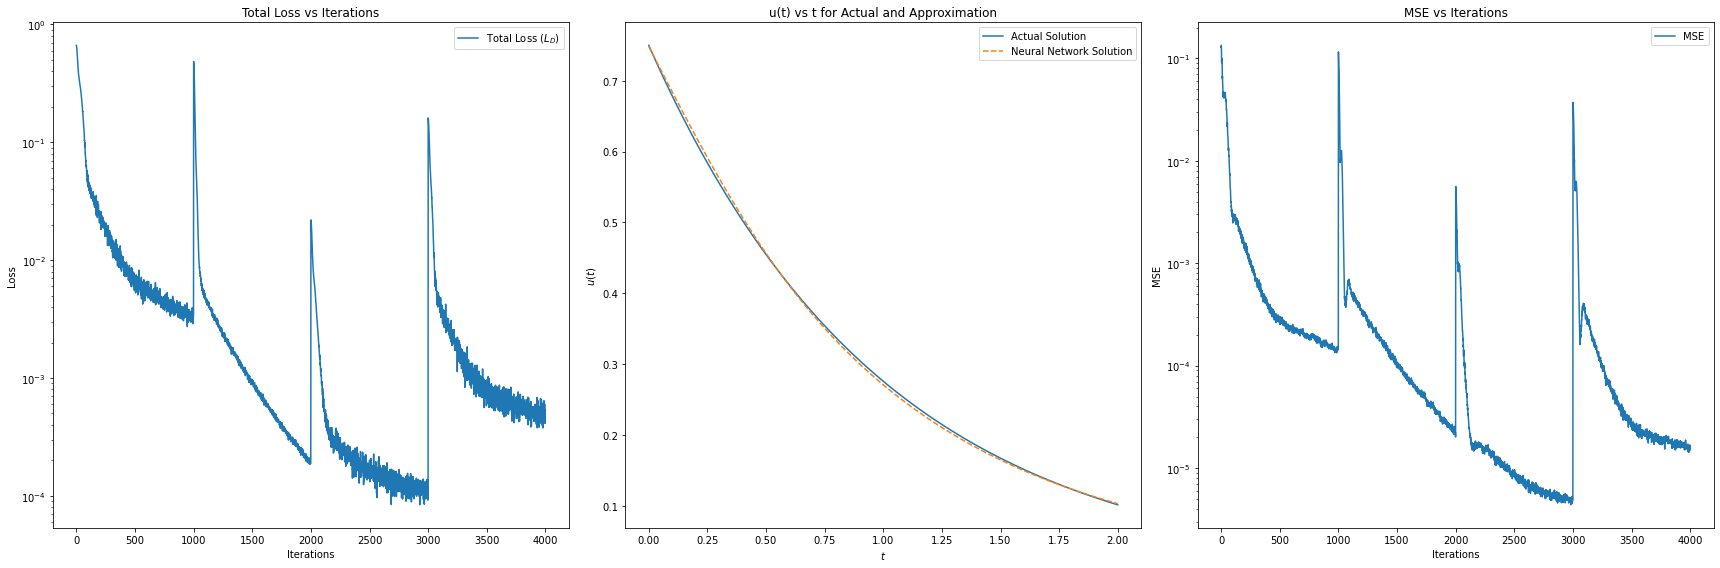

In [44]:
# plot overall loss and network solution for model which has a loss of the MSE (i.e. no higher order terms)
print("\n Model 1: Loss = L_D")
plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                       iterations=iterations, trained_model=trained_model_w1, 
                       train_losses=loss_history_w1['Ltotal_losses'], 
                       loss_label='Total Loss ($L_D$)', mses=MSE_w1)

# # plot overall loss and network solution for model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
# print("\n Model 2: Loss = L_D + L_DD")
# plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, 
#                        iterations=iterations, trained_model=trained_model_w2, 
#                        train_losses=loss_history_w2['Ltotal_losses'], 
#                        loss_label='Total Loss ($L_D + L_{DD}$)', mses=MSE_w2)

# # plot overall loss and network solution for model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
# print("\n Model 3: Loss = L_D + L_DD + L_DDD")
# plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, 
#                        iterations=iterations, trained_model=trained_model_w3, 
#                        train_losses=loss_history_w3['Ltotal_losses'], 
#                        loss_label='Total Loss ($L_D + L_{DD} + L_{DDD}$)', mses=MSE_w3)

# # plot overall loss and network solution for model which has a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
# print("\n Model 4: Loss = L_D + L_DD + L_DDD + L_DDDD")
# plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, 
#                        iterations=iterations, trained_model=trained_model_w4, 
#                        train_losses=loss_history_w4['Ltotal_losses'], 
#                        loss_label='Total Loss ($L_D + L_{DD} + L_{DDD} + L_{DDDD}$)', mses=MSE_w4)


In [ ]:
# plot of differential equation residual (L_D) for each updated model
plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D$)' : loss_history_w1['LD_losses'],
                                        '$L_D$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LD_losses'],
                                        '$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LD_losses'],
                                        '$L_D$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LD_losses']})

# # plot of L_D and L_DD when using a loss of the residual and the first derivative of the residual (i.e. one higher order term)
# plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LD_losses'], 
#                                         '$L_{DD}$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LDD_losses']})

# # plot of L_D, L_DD, and L_DDD when using a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
# plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LD_losses'], 
#                                         '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LDD_losses'],
#                                         '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LDDD_losses']})

# # plot of L_D, L_DD, L_DDD, and L_DDDD when using a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
# plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LD_losses'], 
#                                         '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDD_losses'],
#                                         '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDDD_losses'],
#                                         '$L_{DDDD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDDDD_losses']})


In [50]:
# rng = np.random.default_rng()
# test_t = torch.arange(0, 2, 0.001, requires_grad=True)
# test_t = test_t[rng.integers(low=0, high=2000, size=500)]
# test_t = test_t.reshape(-1, 1)

test_t = torch.tensor([[0.4],[0.31]], dtype=torch.float32, requires_grad=True) 

output, H = trained_model_w1(test_t)
H


tensor([[-0.0716, -0.0927,  0.4857, -0.3439, -0.0597, -0.2203, -0.2490,  0.1547,
         -0.2447],
        [-0.0962, -0.0521,  0.4922, -0.3494, -0.0991, -0.2345, -0.2285,  0.1609,
         -0.2642]], grad_fn=<TanhBackward0>)

In [49]:
a = torch.autograd.grad(H, test_t, grad_outputs=torch.ones_like(H), 
                                 create_graph=True)[0]

a
# print(H)
# should be vector of length 32?

tensor([[0.3241],
        [0.3317]], grad_fn=<MmBackward0>)

In [47]:
# torch.autograd.functional.jacobian(trained_model_w1 ,test_t)[1]

tensor([[[[ 0.2583],
          [ 0.0000]],

         [[-0.4305],
          [ 0.0000]],

         [[-0.0749],
          [ 0.0000]],

         [[ 0.0621],
          [ 0.0000]],

         [[ 0.4247],
          [ 0.0000]],

         [[ 0.1517],
          [ 0.0000]],

         [[-0.2043],
          [ 0.0000]],

         [[-0.0756],
          [ 0.0000]],

         [[ 0.2127],
          [ 0.0000]]],


        [[[ 0.0000],
          [ 0.2872]],

         [[ 0.0000],
          [-0.4697]],

         [[ 0.0000],
          [-0.0691]],

         [[ 0.0000],
          [ 0.0594]],

         [[ 0.0000],
          [ 0.4516]],

         [[ 0.0000],
          [ 0.1630]],

         [[ 0.0000],
          [-0.2493]],

         [[ 0.0000],
          [-0.0617]],

         [[ 0.0000],
          [ 0.2204]]]])

In [ ]:
# CHANGES

# 1. removed the norm_term = 1 / u_t(torch.tensor([[0]], dtype=torch.float32)) ** 2 --> still necessary?

# 2. changed the trial solution to u_t = lambda t: model(t)

# 3. due to 2., changed all other dependent code to use model(t) as opposed to parametrized trial solution

# 4. extract H from the model


In [ ]:
# from sympy import*

# u, t = symbols('u t')
# u_t = Function('u')(t)
# deriv_funct = diff(u_t)
# forcing_funct = -lambda_val * funct **2 # this is the forcing function

# # everything above this needs to be defined in the calling code

# du_dt = diff(forcing_funct, t)
# print(du_dt) 

# a = du_dt.subs(funct, t+1)
# print(a)

# res = du_dt.subs(deriv_funct, t)

# print(res)

# # ans = lambdify([t], res)
# # print(ans(1))

In [ ]:
# Completed Tasks: 

    # TODO 4: TIME CODE --> time the training correctly so we know time for L_D, L_DD, and L_DDD (entire run_model but only the relevant "L_D" terms)

    # TODO 5: ADD MSE PLOTS --> we know analytic solution, compare MSE now for 111, 100, 110 --> MSE will be very small

    # TODO 3: why is f_t and f_tt dependent on t and outputs? --> change code in loss to remove this

    # TODO 6: keep adding L_D terms -->  keep adding L_D terms until diminishing returns are evident in plot

    # TODO 8: change long number of returned items to a dictionary being returned

    # TODO 10: TRY more complex architeture

    # TODO 2: ask/learn about manufactured solution
    
    # TODO 12: watch section 13 of the long video
    
    # TODO 11: fully read one shot transfer learning paper


# Appendix

### Questions: 

- what is the purpose of dividing by U_0 squared in loss?

- why would increasing A makes it more difficult for the network to get the solution?

- Why isn't MSE same as loss for L_D


### Notes:

- $u_t = lambda$ $t: A + t * model(t)$ is outdated, so we use $ u_t = lambda$ $t: A + (1 - exp(-t)) * model(t)$

- We are solving $\frac{du}{dt} + \lambda * u = 0$ where $f = -\lambda * u$

### Todo:

- Automatically compute derivatives as opposed to doing it by hand
- Try loss change by doing $L = \left(\frac{\frac{du}{dt} + \lambda u}{u_0}\right)^2$ or make $u_0$ equal to $\bar u$, in which case the denominator would have to be detached from the computational graph